###  Neur 608 
### Week 2: Brainstat-python tutorial 
### For matlab, see http://brainstat.readthedocs.io 

### some first data exploration 

In [112]:
# we first want to load brainspace sample data 
import matplotlib as mpl 
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data

# Load imaging data & behavioral markers
thickness, demographics = fetch_mics_data()
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")


In [114]:
print(thickness)
print(demographics)

[[3.17593884 2.20165253 2.66589093 ... 3.02698898 2.963866   2.84486079]
 [3.4614718  2.57499719 2.93309331 ... 3.36043596 3.19488454 2.95802307]
 [3.11488891 2.13198256 2.80831814 ... 3.17158246 3.09935522 2.96987009]
 ...
 [2.96797013 2.29708552 2.47753572 ... 2.42349172 2.50966883 2.57557988]
 [3.10503459 2.7157402  2.59255004 ... 3.08738923 3.11856866 3.10049057]
 [3.0598309  2.78424072 2.66205859 ... 3.32902479 3.36127806 3.27317238]]
    SUB_ID  VISIT  AGE_AT_SCAN SEX
0   031404      1           27   F
1   04a144      1           25   M
2   0b78f1      1           33   M
3   0d26b9      1           36   F
4   1988b8      1           31   M
..     ...    ...          ...  ..
77  f25714      1           30   F
78  f25714      2           33   F
79  f615a5      1           26   F
80  feac6b      1           26   F
81  feac6b      2           29   F

[82 rows x 4 columns]


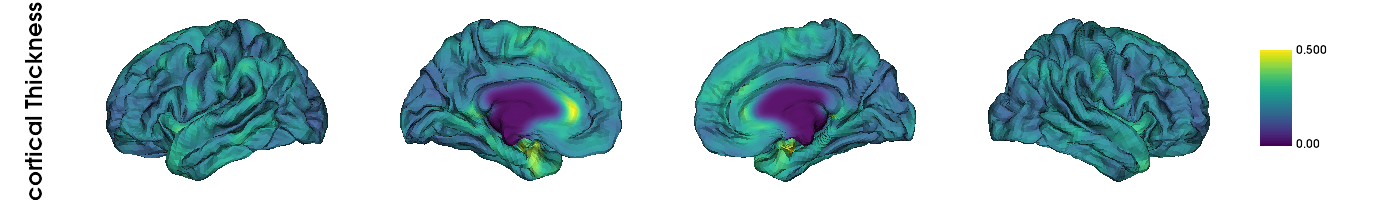

In [117]:
# define & test the plotting functionality 
import numpy as np
from brainspace.plotting import plot_hemispheres

def local_plot_hemispheres(values, label_text, color_range, cmap="viridis"):
    # Plot cortical surfaces with values as the data, label_text as
    # the labels, and color_range as the limits of the color bar.
    return plot_hemispheres(
        pial_left,
        pial_right,
        values,
        color_bar=True,
        color_range=color_range,
        label_text=label_text,
        cmap=cmap,
        embed_nb=True,
        size=(1400, 200),
        zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1),
        cb__labelTextProperty={"fontSize": 12},
        interactive=False,
    )


local_plot_hemispheres(np.std(thickness, axis=0), ["Mean cortical Thickness in mm"], (0, 0.5))

/usr/local/lib/python3.9/site-packages/brainspace/vtk_interface/wrappers/data_object.py:166: UserWarning: Input array is boolean. Casting to uint8.
  warnings.warn('Input array is boolean. Casting to uint8.')


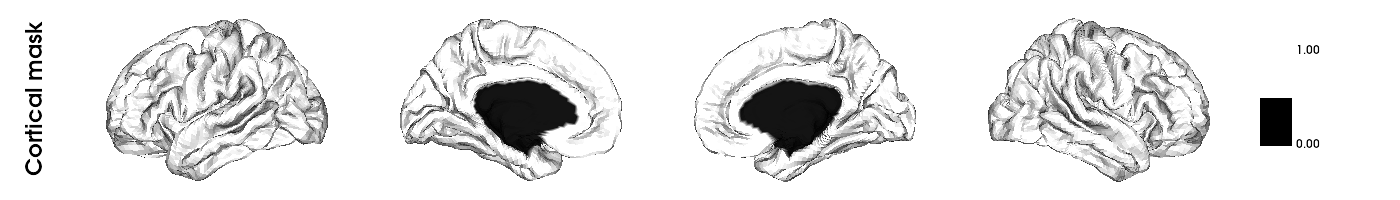

In [118]:
# plot mask, no worries its boolean 
local_plot_hemispheres(mask,["Cortical mask"],(0,1), cmap='gray')

In [119]:
# demographics from MICS
print(demographics)

    SUB_ID  VISIT  AGE_AT_SCAN SEX
0   031404      1           27   F
1   04a144      1           25   M
2   0b78f1      1           33   M
3   0d26b9      1           36   F
4   1988b8      1           31   M
..     ...    ...          ...  ..
77  f25714      1           30   F
78  f25714      2           33   F
79  f615a5      1           26   F
80  feac6b      1           26   F
81  feac6b      2           29   F

[82 rows x 4 columns]


### Model fitting business then 

In [122]:
# here we define fixed effects (Subjects could be a random effect)
from brainstat.stats.terms import FixedEffect
from brainstat.stats.terms import MixedEffect

term_age = FixedEffect(demographics.AGE_AT_SCAN)
term_sex = FixedEffect(demographics.SEX)
term_sub = MixedEffect(demographics.SUB_ID)
model = term_age + term_sex + term_sub

In [123]:
# define contrast and fit linear model to data 
from brainstat.stats.SLM import SLM

contrast_age = demographics.AGE_AT_SCAN
slm_age = SLM(
    model,
    contrast_age,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_age.fit(thickness)

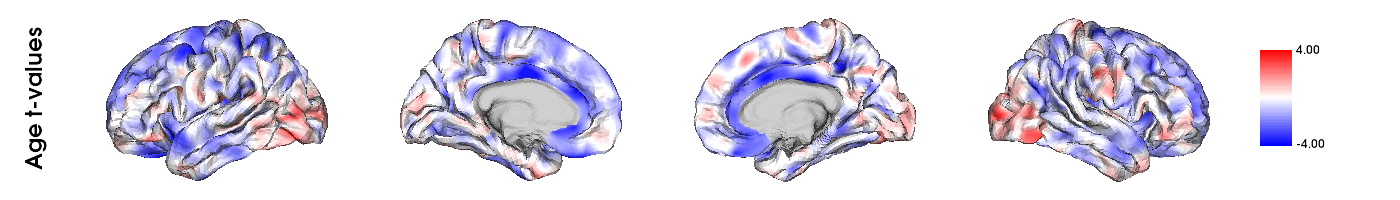

In [124]:
# plot t-stat 
local_plot_hemispheres(slm_age.t, ["Age t-values"], (-4, 4), "bwr")

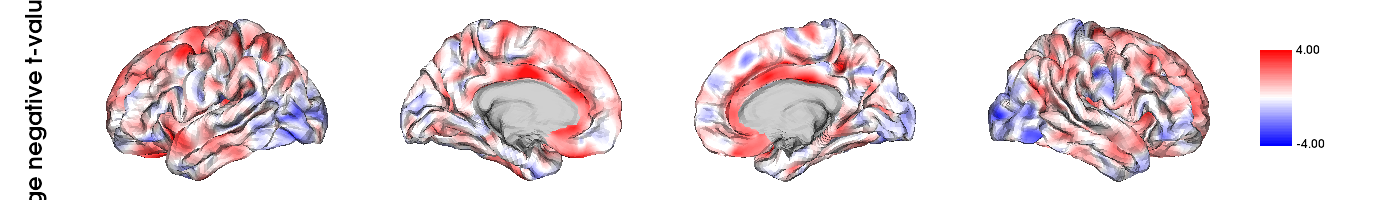

In [110]:
# the other way round
local_plot_hemispheres(-slm_age.t, ["Age negative t-values"], (-4, 4), "bwr")

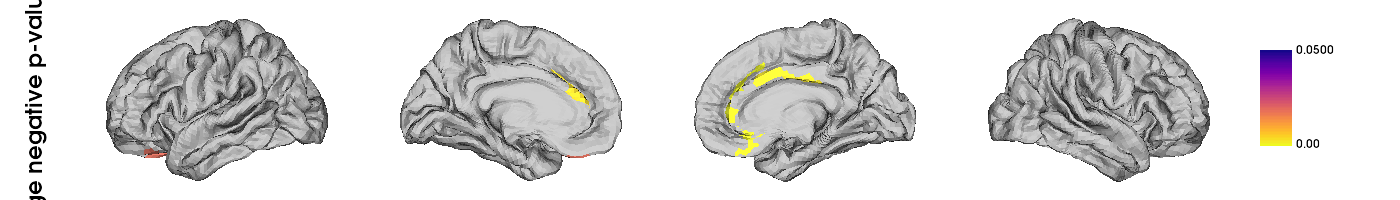

In [126]:
# coplicated sorcery
plot_pvalues = [np.copy(slm_age.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in plot_pvalues]
local_plot_hemispheres(plot_pvalues, ["Age negative p-values"], (0, 0.05), "plasma_r")

In [127]:
print(slm_age.P["clus"][1])

    clusid  nverts    resels         P
0        1   130.0  6.331180  0.000034
1        2    82.0  4.336229  0.001018
2        3    71.0  4.079275  0.001659
3        4    64.0  3.216925  0.009209
4        5    58.0  2.692330  0.027676
..     ...     ...       ...       ...
72      73     1.0  0.046004  1.000000
73      74     1.0  0.044077  1.000000
74      75     1.0  0.037576  1.000000
75      76     1.0  0.033846  1.000000
76      77     1.0  0.018926  1.000000

[77 rows x 4 columns]


In [74]:
print(slm_age.P["peak"][1])

            t  vertid  clusid          P               yeo7
0    5.695420   18720      11   0.001248  Ventral Attention
1    5.164823    5430      12   0.009035             Limbic
2    4.855500   16911       6   0.027242  Ventral Attention
3    4.833974   19629       2   0.029335     Frontoparietal
4    4.628306   12603      14   0.059519       Default mode
..        ...     ...     ...        ...                ...
109  2.403000    2276      62  23.356468  Ventral Attention
110  2.394788    2185      74  23.709038       Default mode
111  2.389922   14687      76  23.918494       Default mode
112  2.382012    6087      64  24.258914       Default mode
113  2.375295    3243      72  24.548027       Default mode

[114 rows x 5 columns]


### then some covariance analysis 

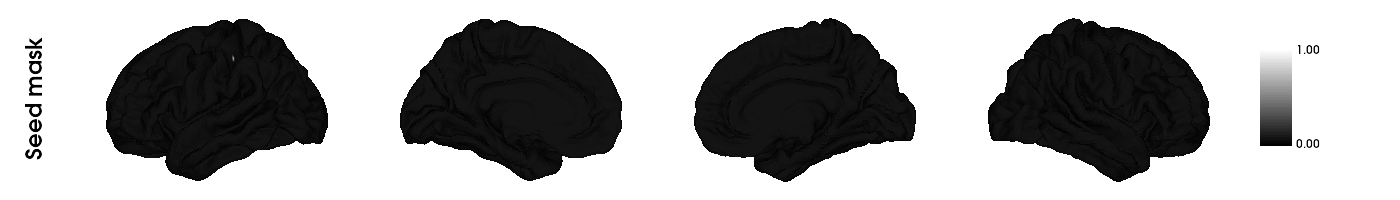

In [132]:
## covariance analysis from a given seed, plot seed first
a = thickness.shape[1]
Seed_index = 700; 
Seed_mask = np.zeros(a)
Seed_mask[Seed_index] = 1
local_plot_hemispheres(Seed_mask,["Seed mask"],(0,1), cmap='gray')

In [133]:
# then run the thing 
Seed = thickness[:,Seed_index]
term_seed = FixedEffect(Seed)
term_age = FixedEffect(demographics.AGE_AT_SCAN)
model = term_age + term_seed + term_sub

contrast_seed = Seed
slm_seed = SLM(
    model,
    contrast_seed,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_seed.fit(thickness)

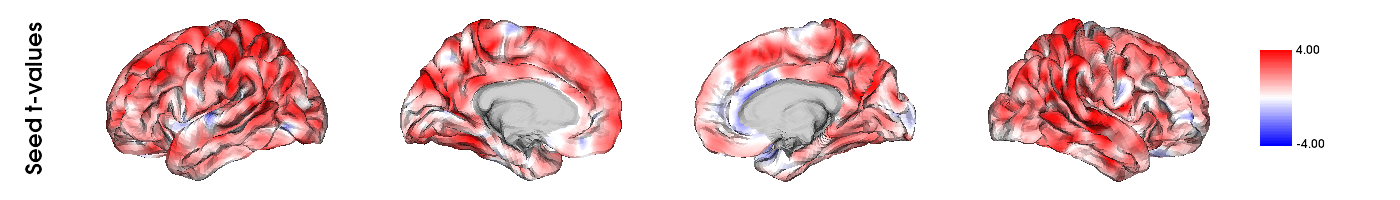

In [134]:
local_plot_hemispheres(slm_seed.t, ["Seed t-values"], (-4, 4), "bwr")

### then some context decoding 

In [135]:
# some context decoding, here against neurosynth 

from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud
import matplotlib.pyplot as plt

2022-09-16 13:01:39,312 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-09-16 13:01:39,547 - brainstat - INFO - Running correlations with all Neurosynth features.
                        Pearson's r
grasping                   0.029361
index finger               0.028397
anterior intraparietal     0.027349
tactile                    0.025046
finger                     0.024191
...                             ...
facial expression         -0.005634
disease ad                -0.005821
ad                        -0.006708
psychosis                 -0.007164
abnormality               -0.007786

[3228 rows x 1 columns]


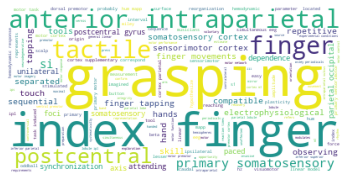

In [136]:
meta_analysis = meta_analytic_decoder("fsaverage5", slm_seed.t.flatten())
print(meta_analysis)

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

2022-09-15 19:28:15,502 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-09-15 19:28:15,659 - brainstat - INFO - Running correlations with all Neurosynth features.
                    Pearson's r
temporal pole          0.306035
frontotemporal         0.256265
anterior temporal      0.245026
pole                   0.240730
insular cortex         0.222525
...                         ...
primary visual        -0.214836
visual field          -0.215422
early visual          -0.223112
occipital parietal    -0.228742
v1                    -0.284811

[3228 rows x 1 columns]


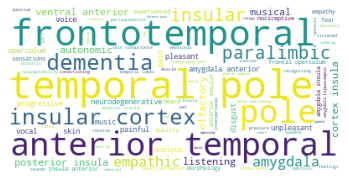

In [97]:
# can also do this on a different type of feature 
meta_analysis = meta_analytic_decoder("fsaverage5", np.mean(thickness, axis=0))
print(meta_analysis)

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

In [98]:
## or decode nilearn results 
from nilearn.datasets import fetch_language_localizer_demo_dataset
data_dir, _ = fetch_language_localizer_demo_dataset()

from nilearn.glm.first_level import first_level_from_bids
task_label = 'languagelocalizer'
_, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])




/usr/local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:901: UserWarning: SliceTimingRef not found in file /Users/boris/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


In [99]:
# obtain first level Model objects and arguments 
from nilearn.glm.first_level import first_level_from_bids
task_label = 'languagelocalizer'
_, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

/usr/local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:901: UserWarning: SliceTimingRef not found in file /Users/boris/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


In [51]:
import os
json_file = os.path.join(data_dir, 'derivatives', 'sub-01', 'func',
                         'sub-01_task-languagelocalizer_desc-preproc_bold.json')
import json
with open(json_file, 'r') as f:
    t_r = json.load(f)['RepetitionTime']

In [52]:
# project onto fsaverage
from nilearn.datasets import fetch_surf_fsaverage
fsa = fetch_surf_fsaverage(mesh='fsaverage5')

In [53]:
import numpy as np
from nilearn import surface
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast

In [56]:
z_scores_right = []
z_scores_left = []
for (fmri_img, confound, events) in zip(
        models_run_imgs, models_confounds, models_events):
    texture = surface.vol_to_surf(fmri_img[0], fsa.pial_right)
    n_scans = texture.shape[1]
    frame_times = t_r * (np.arange(n_scans) + .5)

    # Create the design matrix
    #
    # We specify an hrf model containing Glover model and its time derivative.
    # The drift model is implicitly a cosine basis with period cutoff 128s.
    design_matrix = make_first_level_design_matrix(
        frame_times, events=events[0], hrf_model='glover + derivative',
        add_regs=confound[0])

    # Contrast specification
    contrast_values = (design_matrix.columns == 'language') * 1.0 -\
                      (design_matrix.columns == 'string')

    # Setup and fit GLM.
    # Note that the output consists in 2 variables: `labels` and `fit`
    # `labels` tags voxels according to noise autocorrelation.
    # `estimates` contains the parameter estimates.
    # We input them for contrast computation.
    labels, estimates = run_glm(texture.T, design_matrix.values)
    contrast = compute_contrast(labels, estimates, contrast_values,
                                contrast_type='t')
    # We present the Z-transform of the t map.
    z_score = contrast.z_score()
    z_scores_right.append(z_score)

    # Do the left hemisphere exactly the same way.
    texture = surface.vol_to_surf(fmri_img, fsa.pial_left)
    labels, estimates = run_glm(texture.T, design_matrix.values)
    contrast = compute_contrast(labels, estimates, contrast_values,
                                contrast_type='t')
    z_scores_left.append(contrast.z_score())

In [57]:
from scipy.stats import ttest_1samp, norm
t_left, pval_left = ttest_1samp(np.array(z_scores_left), 0)
t_right, pval_right = ttest_1samp(np.array(z_scores_right), 0)

In [58]:
z_val_left = norm.isf(pval_left)
z_val_right = norm.isf(pval_right)

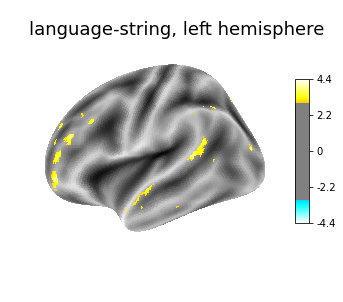

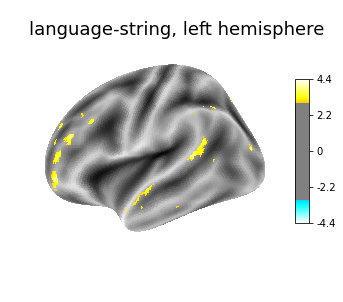

In [60]:
from nilearn import plotting
plotting.plot_surf_stat_map(
    fsa.infl_left, z_val_left, hemi='left',
    title="language-string, left hemisphere", colorbar=True,
    threshold=3., bg_map=fsa.sulc_left)

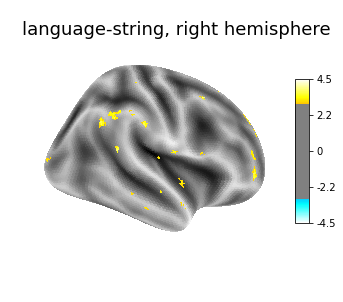

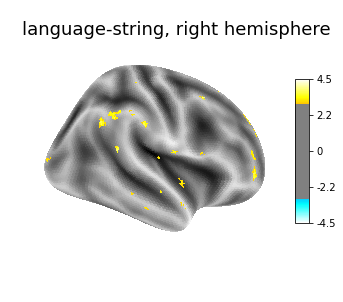

In [61]:
plotting.plot_surf_stat_map(
    fsa.infl_right, z_val_right, hemi='right',
    title="language-string, right hemisphere", colorbar=True,
    threshold=3., bg_map=fsa.sulc_right)

2022-09-14 22:04:16,883 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-09-14 22:04:17,090 - brainstat - INFO - Running correlations with all Neurosynth features.
                   Pearson's r
anterior temporal     0.185128
psts                  0.133614
mental states         0.130454
theory mind           0.129125
mind tom              0.121663
...                        ...
obsessive            -0.140579
sensation            -0.146399
painful              -0.153477
noxious              -0.156961
nociceptive          -0.162399

[3228 rows x 1 columns]


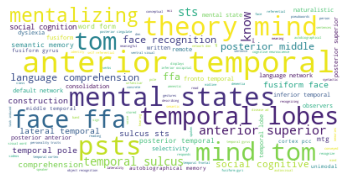

In [63]:
map = np.concatenate([z_val_left,z_val_right])
meta_analysis = meta_analytic_decoder("fsaverage5", map)
print(meta_analysis)

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()